In [1]:
import os
from pyspark.sql import SparkSession
# Import PandasUDFType from the corrected location (functions)
from pyspark.sql.functions import PandasUDFType 

# Set environment variables for the current notebook kernel
user_home = os.environ['HOME']
java_target_dir = os.path.join(user_home, "java_home")
java_bin_dir = os.path.join(java_target_dir, "bin")

os.environ["JAVA_HOME"] = java_target_dir
os.environ["PATH"] = java_bin_dir + os.pathsep + os.environ["PATH"]

# Initialize Spark Session with Optimal Memory Settings for 32 Cores
# Total RAM: 224G. Driver: 16G. Executor: ~200G. Cores: 30.
spark = SparkSession.builder \
    .appName("Parallel_MCMC_Model_Fit") \
    .master("local[*]") \
    .config("spark.executor.cores", "30") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "200g") \
    .config("spark.driver.maxResultSize", "0") \
    .config("spark.python.worker.memory", "6g") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()
    
print(f"Spark Session initialized! Driver: 16G, Executor: 200G, Cores: 30.")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/07 14:30:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark Session initialized! Driver: 16G, Executor: 200G, Cores: 30.


In [2]:
import pandas as pd
import numpy as np
import re
from functools import reduce
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
from pyspark.sql.functions import pandas_udf, col, lit
from pyspark.sql.types import StructType, StructField, StringType, DoubleType
from pyspark.sql.functions import PandasUDFType

In [ ]:
xml_path = "segment4_final.xml"
rates_path = "log_rates.csv"

# Define the schema for the output of the parallel UDF
# The UDF will output a table with columns: (mcmc_state, predictor, importance)
output_schema = StructType([
    StructField("mcmc_state", StringType(), True),
    StructField("predictor", StringType(), True),
    StructField("importance", DoubleType(), True)
])

# Load transition rates (still best in Pandas for simple I/O)
transition_df = pd.read_csv(rates_path, index_col=0)

In [ ]:
# Extract state codes from XML
xml_districts = []
read_loc = False
with open(xml_path, 'r') as f:
    for line in f:
        if 'state.dataType' in line:
            read_loc = True
        m = re.search(r'<state code="([A-Za-z_]+)"/>', line)
        if read_loc and m:
            xml_districts.append(m.group(1))

print(f"\nNumber of datatypes: {len(xml_districts)}")

# Extract predictor matrices from XML
predictor_matrices = {}
pattern = re.compile(r'<parameter id="([A-Za-z0-9_.]+)" value="([0-9.\- E]+)"')
design_matrix = False
counter = 0
N = len(xml_districts)

with open(xml_path, 'r') as f:
    for line in f:
        if '<designMatrix' in line:
            design_matrix = True
        if design_matrix:
            found = pattern.search(line)
            if found:
                pred_name = found.group(1)
                values = list(map(float, found.group(2).split()))
                if len(values) == (N*N - N): # N*(N-1)
                    predictor_matrices[pred_name] = values
                    counter += 1

print(f"\n Predictors found in file: {counter}")

# reshape and merge
predictor_dfs = []

for name, flat_vec in predictor_matrices.items():
    # Convert flat vector into full square matrix with NaN diagonal
    mat = np.zeros((N, N))
    mat[:] = np.nan
    idx = 0
    for i in range(N):
        for j in range(N):
            if i != j:
                mat[i, j] = flat_vec[idx]
                idx += 1

    # Convert to DataFrame and melt into long dyadic format
    df = pd.DataFrame(mat, index=xml_districts, columns=xml_districts)
    long_df = (
        df.reset_index()
          .melt(id_vars="index", var_name="destination", value_name=name)
          .rename(columns={"index": "origin"})
    )
    predictor_dfs.append(long_df)

# Merge all predictors into one dyadic table
predictors_df = reduce(lambda left, right: pd.merge(left, right, on=["origin", "destination"]),
                         predictor_dfs)

print(f"Predictor matrix shape (from XML): {predictors_df.shape}")

# Merge with transition rates
merged_pd = transition_df.merge(predictors_df, on=["origin", "destination"], how="inner")
print(f"Merged data shape: {merged_pd.shape}")

# Identify predictor columns for the model
predictor_cols = [c for c in predictors_df.columns if c not in ["origin", "destination"]]

# clean column names
# Replace dots with underscores to prevent Spark AnalysisException
merged_pd.columns = [c.replace('.', '_') for c in merged_pd.columns]
predictors_df.columns = [c.replace('.', '_') for c in predictors_df.columns]
predictor_cols = [c.replace('.', '_') for c in predictor_cols]
# Re-initialize the list of predictor columns for the UDF, excluding the target and key variables.
EXCLUDED_COLS = ["origin", "destination", "mcmc_state", "transition_rate", "migration_count", "total_branch_length", "log_transition_rate", "log_migration_count"]
predictor_cols = [c for c in merged_pd.columns if c not in EXCLUDED_COLS]
print(f"Cleaned predictor columns count: {len(predictor_cols)}")


Number of datatypes: 14

 Predictors found in file: 19
Predictor matrix shape (from XML): (196, 21)
Merged data shape: (16380182, 27)
Cleaned predictor columns count: 19


In [ ]:
# Ensure 'mcmc_state' is a string type for Spark compatibility
merged_pd['mcmc_state'] = merged_pd['mcmc_state'].astype(str)
print(f"MCMC state dtype converted to: {merged_pd['mcmc_state'].dtype}")

# Convert the final Pandas DataFrame into a Spark DataFrame
merged_spark = spark.createDataFrame(merged_pd)

print("Data frame converted")

MCMC state dtype converted to: object
Data frame converted


In [ ]:
@pandas_udf(output_schema, functionType=PandasUDFType.GROUPED_MAP)
def fit_boosted_tree(pdf: pd.DataFrame) -> pd.DataFrame:
    """
    Fits a Gradient Boosting regression model to data from a single
    MCMC state group.

    Args:
        pdf (pandas.DataFrame): A DataFrame containing data for exactly one
            MCMC state group. Must include the columns "mcmc_state",
            "log_transition_rate", and all predictors specified in
            `predictor_cols`.

    Returns:
        pandas.DataFrame: A DataFrame containing feature importance values
            from the fitted Gradient Boosting model with the following columns:
            - mcmc_state: Identifier of the MCMC state.
            - predictor: Name of the predictor variable.
            - importance: Relative importance of the predictor.
            If the response variable has zero variance, an empty DataFrame
            with the appropriate columns is returned.

    Docstring generated with ChatGPT 5.2.
    """
    state_id = pdf["mcmc_state"].iloc[0]
    
    X = pdf[predictor_cols].values
    y = pdf["log_transition_rate"].values
    
    # Skip if response has no variance
    if np.std(y) == 0:
        return pd.DataFrame([], columns=["mcmc_state", "predictor", "importance"])
    
    # Boosted Tree Model
    model = GradientBoostingRegressor(
        n_estimators=400,
        max_depth=3,
        learning_rate=0.05,
        subsample=0.7,
        random_state=42
    )
    model.fit(X, y)
    
    # Create the output dataframe of feature importances
    importance_df = pd.DataFrame({
        "mcmc_state": state_id,
        "predictor": predictor_cols,
        "importance": model.feature_importances_
    })
    
    return importance_df

# Apply the UDF to the Spark DataFrame grouped by mcmc_state
imp_spark = merged_spark.groupBy("mcmc_state").apply(fit_boosted_tree)

# Collect the results back to the driver as a Pandas DataFrame for final analysis
imp_df = imp_spark.toPandas()

print(f"Total importance records collected: {len(imp_df)}")

/scratch/lustre/home/inbl0117/.local/lib/python3.8/site-packages/pyspark/sql/pandas/group_ops.py:104: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(
25/12/07 14:30:58 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
25/12/07 14:30:58 WARN TaskSetManager: Stage 0 contains a task of very large size (2197 KiB). The maximum recommended task size is 1000 KiB.


Total importance records collected: 1710019



Boosted Tree Feature Importance Summary:
                                            predictor      mean    median  \
4                 state_capital_distance_km_offsetlog  0.129470  0.116914   
17  state_yearly_precipitation_destination_logtran...  0.105062  0.107344   
12             state_swine_trade_exp_origin_offsetlog  0.086509  0.101338   
14       state_total_cattle_stock_origin_logtransform  0.068094  0.076310   
15   state_total_swine_stock_destination_logtransform  0.067430  0.066074   
16        state_total_swine_stock_origin_logtransform  0.066277  0.069317   
6             state_cattle_trade_exp_origin_offsetlog  0.062939  0.057442   
5        state_cattle_trade_exp_destination_offsetlog  0.058394  0.060573   
18     state_yearly_precipitation_origin_logtransform  0.054729  0.055611   
3            state_agro_land_perc_origin_logtransform  0.051773  0.052527   
9    state_mean_temperatures_destination_logtransform  0.047253  0.047979   
0       state_GDP_per_capita_desti

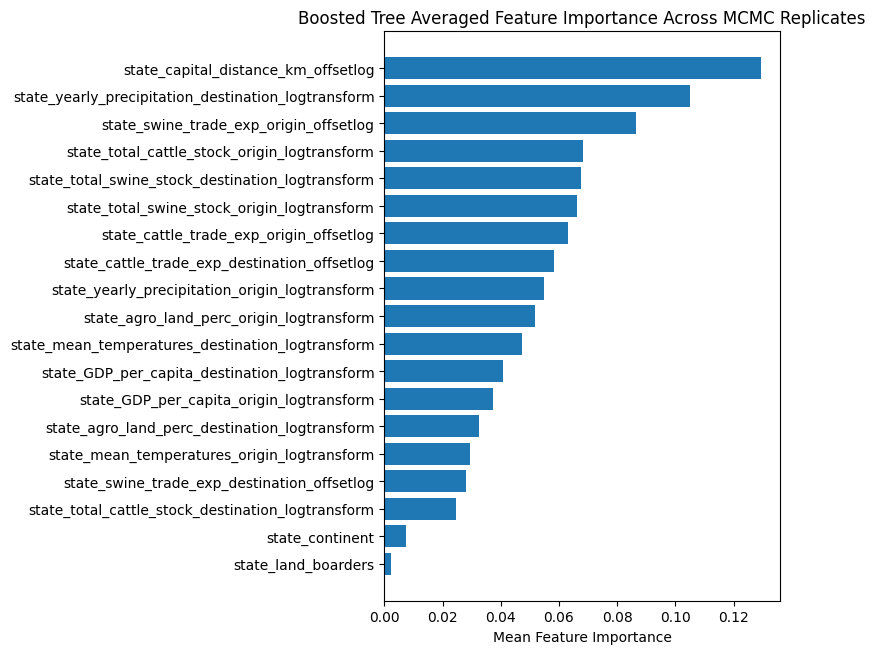

Saved tree_plot_main.png


In [ ]:
# Average importance across MCMC replicates
summary_imp = (
    imp_df.groupby("predictor")["importance"]
    .agg(["mean", "median", "std"])
    .reset_index()
    .sort_values("mean", ascending=False)
)

print("\nBoosted Tree Feature Importance Summary:")
print(summary_imp)

# Save summary
summary_imp.to_csv("res_log/tree_summary_main.csv", index=False)
print("Saved tree_summary_main.csv")


# averaged importance plot

plt.figure(figsize=(8, max(6, 0.35 * len(summary_imp))))
plt.barh(summary_imp["predictor"], summary_imp["mean"])
plt.xlabel("Mean Feature Importance")
plt.title("Boosted Tree Averaged Feature Importance Across MCMC Replicates")
plt.gca().invert_yaxis()  # largest on top
plt.tight_layout()
plt.savefig("res_log/tree_plot_main.png", dpi=300)
plt.show()

print("Saved tree_plot_main.png")

# Stop the Spark Session
spark.stop()